# Phase transition in a hard-disk fluid

In [5]:
include("gnuplot.jl");

## The box

A box is created with random points. This points will become the centers of particles of a given radius. Notice that the distance from point to point (or center to center) restricts the possible radii that the particles can take without overlapping. To get any desired radius is just a matter of rescaling the system.

In [6]:
mutable struct Particle
    x::Float64
    y::Float64
    radius::Float64
end

struct Rectangle
    w::Float64
    h::Float64
    x::Float64
    y::Float64
end

mutable struct QuadTree
    boundary::Rectangle
    capacity::Int
    particles::Vector{Particle}
    divided::Bool
    tr::QuadTree
    tl::QuadTree
    br::QuadTree
    bl::QuadTree
    QuadTree(boundary, capacity) = new(boundary, capacity,
        [], false)
end

mutable struct Box
    width::Float64
    height::Float64
    
    particles::Vector{Particle}
    
    quadtree::QuadTree
    
    function Box(n::Int, radii::Vector{Float64})
        # Random particles inside a unit box.
        particles = [Particle(rand(),rand(),rand(radii)) for i in 1:n]
        
        # Get minimum separation distance between all
        # pairs of points.
        ii::Int = 1
        jj::Int = 1
        d2::Float64 = Inf
        for i in 1:n-1
            p::Particle = particles[i]
            for j in i+1:n
                q::Particle = particles[j]
                rx::Float64 = p.x - q.x
                ry::Float64 = p.y - q.y
                r2::Float64 = rx*rx + ry*ry
                if r2 < d2
                    ii = i
                    jj = j
                    d2 = r2
                end
            end
        end
        d::Float64 = sqrt(d2)/2.0 - 1e-10

        # Scale the system to get d to have two times
        # the size of the maximum possible radius.
        maxRadius = maximum(radii)
        particles[ii].radius = maxRadius
        particles[jj].radius = maxRadius
        f::Float64 = 2*maxRadius/d # scaling factor
        for p in particles
            p.x = f * p.x + maxRadius
            p.y = f * p.y + maxRadius
        end
        width = f + 2*maxRadius
        height = width    
        
        # Define space partitioning structure
        qt = QuadTree(Rectangle(width, height, 0, 0), 4)
        for p in particles; insert!(qt, p); end
        
        return new(width, height, particles, qt)
    end
end

function getDensity(box::Box)
    area::Float64 = 0
    for p in box.particles
        r::Float64 = p.radius
        area += π*r*r
    end
    return area / (box.width * box.height)
end

function contains(r::Rectangle, p::Particle)
    return r.x < p.x < r.x + r.w && r.y < p.y < r.y + r.h
end

function intersects(r::Rectangle, p::Particle)
    halfwidth::Float64 = r.w/2
    halfheight::Float64 = r.h/2
    x::Float64 = r.x
    y::Float64 = r.y
    radius::Float64 = p.radius

    # Get distance from circle's center to box's center
    dx_circle2center::Float64 = abs(p.x - (x + halfwidth))
    dy_circle2center::Float64 = abs(p.y - (y + halfheight))

    if (dx_circle2center > halfwidth + radius); return false; end
    if (dy_circle2center > halfheight + radius); return false; end

    # Get distance from circle's center to box's corner
    dx_circle2edge::Float64 = dx_circle2center - halfwidth
    dy_circle2edge::Float64 = dy_circle2center - halfheight
    drdr_circle2corner::Float64 = dx_circle2edge * dx_circle2edge + 
                                  dy_circle2edge * dy_circle2edge

    if (dx_circle2center < halfwidth); return true; end
    if (dy_circle2center < halfheight); return true; end
    return drdr_circle2corner < radius*radius
end

function subdivide!(qt::QuadTree)
    w::Float64 = qt.boundary.w/2.0
    h::Float64 = qt.boundary.h/2.0
    x::Float64 = qt.boundary.x
    y::Float64 = qt.boundary.y
    
    trb = Rectangle(w, h, x+w, y+h)
    tlb = Rectangle(w, h, x,   y+h)
    brb = Rectangle(w, h, x+w, y)
    blb = Rectangle(w, h, x,   y)
    
    n::Int = qt.capacity
    qt.tr = QuadTree(trb, n)
    qt.tl = QuadTree(tlb, n)
    qt.br = QuadTree(brb, n)
    qt.bl = QuadTree(blb, n)
    qt.divided = true
end

function search(qt::QuadTree, p::Particle)
    if     contains(qt.tr.boundary, p); return qt.tr
    elseif contains(qt.tl.boundary, p); return qt.tl
    elseif contains(qt.br.boundary, p); return qt.br
    else   contains(qt.bl.boundary, p); return qt.bl
    end
end

isAtCapacity(qt::QuadTree) = length(qt.particles) == qt.capacity

function insert!(qt::QuadTree, p::Particle)
    current::QuadTree = qt
    while current.divided
        current = search(current, p)
    end
    if isAtCapacity(current)
        subdivide!(current)
        current = search(current, p)
    end
    push!(current.particles, p)
end

ErrorException: invalid redefinition of constant QuadTree

## Hard-disks collisions, a montecarlo process

Instead of physically colliding disks inside the box, we are simulating their dynamics with a montecarlo process:

- Randomly pick a disk inside the box and move it in a random direction with magnitude between 0 and 1. 
- If the particle overlaps with another one or if it leaves the box, then return particle to original position.

We can also reduce the volume of the box cuasi-statically to reach an optimal packing.

In [18]:
function overlaps(p::Particle, qt::QuadTree)
    quadtrees::Vector{QuadTree} = [qt]
    while length(quadtrees) > 0
        current::QuadTree = pop!(quadtrees)
        if current.divided
            if intersects(current.tr.boundary, p)
                push!(quadtrees, current.tr)
            end
            if intersects(current.tl.boundary, p)
                push!(quadtrees, current.tl)
            end
            if intersects(current.br.boundary, p)
                push!(quadtrees, current.br)
            end
            if intersects(current.bl.boundary, p)
                push!(quadtrees, current.bl)
            end
        end

        # If there's at least one overlap then
        # just return true.
        for q in current.particles
            if p === q; continue; end
            d::Float64 = p.radius + q.radius
            rx::Float64 = p.x - q.x
            ry::Float64 = p.y - q.y
            if rx*rx + ry*ry < d*d
                return true
            end
        end
    end
    return false
end

function getFirstNonEmptyNonDivided(qt::QuadTree)
    quadtrees::Vector{QuadTree} = [qt]
    while length(quadtrees) > 0
        current::QuadTree = pop!(quadtrees)
        if current.divided
            push!(quadtrees, current.tr,
                current.tl, current.br, current.bl)
        elseif length(current.particles) > 0
            return current
        end
    end
    return qt
end

function findLocation(p::Particle, qt::QuadTree)
    current::QuadTree = qt
    while current.divided
        for q in current.particles
            if p === q; return current; end
        end
        current = search(current, p)
    end
    return current
end

function montecarlo!(box::Box)
    # Random disk
    p::Particle = rand(box.particles)
    radius::Float64 = p.radius
    # Find p's location before moving it.
    location::QuadTree = findLocation(p, box.quadtree)
    
    # Random movement of magnitude ∈ (0,radius).
    x::Float64 = -1 + 2*rand()
    y::Float64 = -1 + 2*rand()
    n::Float64 = sqrt(x*x + y*y) # Norm
    A::Float64 = rand() * radius # Random amplitude
    x = p.x + A*x/n
    y = p.y + A*y/n
    
    # Update particle position but save its previous
    # just in case there's an overlap.
    xp::Float64 = p.x
    yp::Float64 = p.y
    p.x = x
    p.y = y
    
    # Are there any overlaps inside the box?
    w::Float64 = box.width
    h::Float64 = box.height
    if (radius < x < w - radius) && (radius < y < h - radius)
        if overlaps(p, box.quadtree)
            p.x = xp
            p.y = yp
            return
        end
        for q in box.particles
            if p === q; continue; end
            if overlaps(q, box.quadtree)
                p.x = xp
                p.y = yp
                return
            end
        end
        # At this point we know there are no overlaps.
        # If p's container is not divided just re-insert p.
        # else find a non-empty, non-divided container and
        # replace p for a particle in that container, then
        # re-insert p.
        k::Int = findfirst(x -> x === p, location.particles)
        deleteat!(location.particles, k)
        insert!(box.quadtree, p)
        if location.divided
            subqt::QuadTree = getFirstNonEmptyNonDivided(location)
            if subqt !== location
                replacement::Particle = pop!(subqt.particles)
                push!(location.particles, replacement)
            end
        end
    else
        p.x = xp
        p.y = yp
    end
end

function reduceVolume!(box::Box)
    w::Float64 = box.width
    
    rx2wall::Float64 = Inf
    ry2wall::Float64 = Inf
    for p in box.particles
        x::Float64 = w - p.x - p.radius
        y::Float64 = w - p.y - p.radius
        if x < rx2wall; rx2wall = x; end
        if y < ry2wall; ry2wall = y; end
    end
    box.width = w - min(rx2wall, ry2wall)/2.0
    box.height = box.width
    boundary::Rectangle = Rectangle(box.width, box.height, 0, 0)
    qt::QuadTree = QuadTree(boundary, box.quadtree.capacity)
    for p in box.particles; insert!(qt, p); end
    box.quadtree = qt
end

function incrementVolume!(box::Box)
    box.width *= 1.001 # 0.1% increment
    updateGrid!(box)
end

incrementVolume! (generic function with 1 method)

### A fresh new box

Let's start a new box with $n$ disks of radius $r$ and measure its packing fraction $\phi$.

  0.000033 seconds (111 allocations: 7.266 KiB)


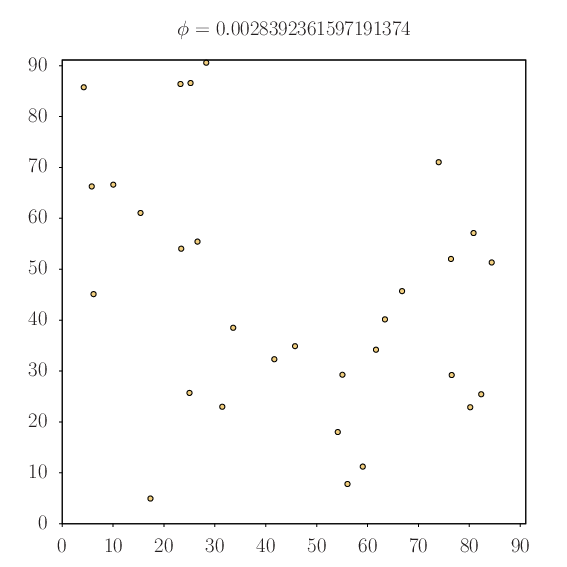

In [25]:
function test()
    n::Int = 30
    radii::Vector{Float64} = [0.5]
    @time box::Box = Box(n,radii)
    w::Float64 = box.width
    h::Float64 = box.height
    phi::Float64 = getDensity(box)

    gp = gnuplot(20, 20)
    println(gp,
        "set size ratio -1;",
        "set tics out nomirror;",
        "set style fill solid 0.5 border 1;",
        "set xrange [0:$w];",
        "set yrange [0:$h];",
        "set title '\$\\phi = $phi\$';",
        "plot '-' with circles lc 2 notitle;")
    for p in box.particles
        println(gp, p.x, " ", p.y, " ", p.radius)
    end
    plot(gp)
    return box
end
box = test();

### An old box

Take the previous box and let the montecarlo process simulate its dynamics. After a given number of montecarlo steps try reducing the system's volume. This way, with each volume reducing step, the packing fraction will increase.

  2.061992 seconds (8.97 M allocations: 726.646 MiB, 4.50% gc time)


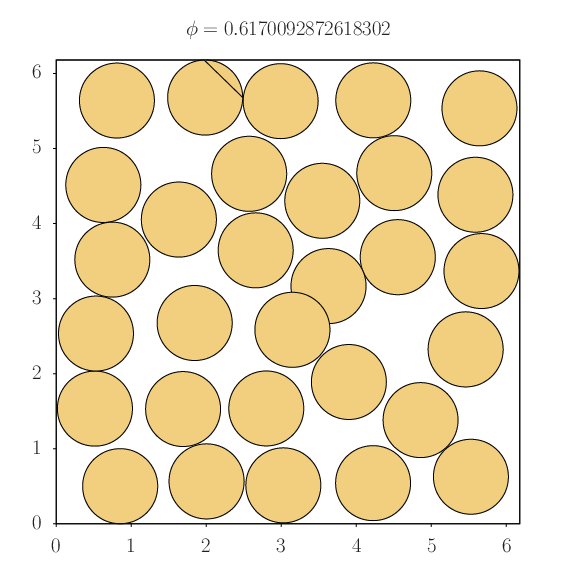

In [26]:
function simulation(box::Box, n::Int)
    steps::Int = length(box.particles)
    @time for i in 1:n
        for k in 1:steps; montecarlo!(box); end
        reduceVolume!(box)
    end

    w::Float64 = box.width
    h::Float64 = box.height
    phi::Float64 = getDensity(box)

    gp = gnuplot(20, 20)
    println(gp,
        "set size ratio -1;",
        "set tics out nomirror;",
        "set style fill solid 0.5 border 1;",
        "set xrange [0:$w];",
        "set yrange [0:$w];",
        "set title '\$\\phi = $phi\$';",
        "plot '-' with circles lc 2 notitle;")
    for p in box.particles
        println(gp, p.x, " ", p.y, " ", p.radius)
    end
    plot(gp)
end
simulation(box, 10000)

## Orientational order parameter

$$ \psi_6(R) = \frac{1}{N}\sum_{j=1}^N \bigg| \frac{1}{n} \sum_{k=1}^n \exp(i 6 \theta_{jk})\bigg| $$

where $R$ is a radius defining a circle concentric with particle $p_j$ and enclosing all particles $p_k$.

In [ ]:
function psi6(pts::Vector{Vector{Float64}}, r::Float64)
    RePsi = 0
    ImPsi = 0
    psi6 = 0
    N = length(pts)
    for p in pts
        n = 0 # count p-neighbours
        for q in pts
            if p === q; continue; end
            rx = q[1] - p[1]
            ry = q[2] - p[2]
            d = rx*rx + ry*ry
            th = atan(ry,rx)
            if d < r
                RePsi += cos(6*th)
                ImPsi += sin(6*th)
                n += 1
            end
        end
        if n > 0
            psi6 += sqrt(RePsi*RePsi + ImPsi*ImPsi)/n
        end
    end
    return psi6/N
end

### Plotting $\psi_6(R)$ for different densities $\phi$.

Plotted in units of the particles' diameter, $d$

In [ ]:
n = 100; r = 0.5
box = Box(n,r)

gp = gnuplot(32,14)
println(gp, "set cblabel '\$\\phi\$'; set palette negative;
    set format x '\$%1.0f d\$'; set ylabel '\$\\psi_6\$';
    set xrange [2*$r:128*$r];
    plot '-' w l lc palette notitle;")
for i in 1:4
    # Change box's density
    for j in 1:20000
        for k in 1:length(box.pts)
            montecarlo!(box)
        end
        reduceVolume!(box)
    end

    # Plot psi6(R) for fixed density
    phi = getDensity(box)
    for R in 2*r:1e-1:128*r
        p = psi6(box.pts, R)
        println(gp, "$R $p $phi")
    end
    println(gp)
end
plot(gp)

### Fixing $R$ and measuring $\psi_6^{(R)}(\phi)$

We observed in the previous result the values of $R$ that make the order parameter a measurable quantity. Taking one of this values we can then slowly change the box's density and measure $\psi_6$ to see where the phase transition takes place.

In [ ]:
n = 100; r = 0.5; R = 10*r;
box = Box(n,r)

gp = gnuplot(32,14)
println(gp, "set xlabel '\$\\phi\$'; set ylabel '\$\\psi_6^{(R)}\$';
    plot '-' w l notitle;")
for i = 1:1000
    phi = getDensity(box)
    psi = psi6(box.pts, R)
    println(gp, "$phi $psi")
    for j in 1:100
        for k in 1:length(box.pts)*2
            montecarlo!(box)
        end
        reduceVolume!(box)
    end
end
plot(gp)

[10] Repite el ejercicio 9, esta vez comenzando con un sistema muy denso y ordenado para después bajar la densidad. 

[11] Prueba diferentes velocidades con las que incrementes o disminuyas la densidad cerca del punto crítico. 